# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.71KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

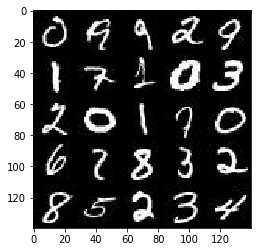

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

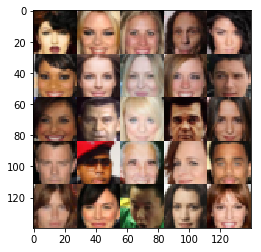

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [75]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32)
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [91]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        #start dim = 28 x 28 x ?
        #x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        x1 = tf.maximum(alpha * x1, x1)
        #now 14 x 14 x 64
        
        #x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        #now 7 x 7 x 128
        
        #x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        #now 7 x 7 x 256
        
        flat = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [92]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    #print("out_channel_dim=" + str(out_channel_dim))
    with tf.variable_scope('generator', reuse=(not is_train)):
        # Output needs to be 28 x 28 x out_channel_dim
        # If we want say 3 layers (incl output), doubliing the dimensions each time we would need:
        # x1:  7,7,512
        # x2:  14,14,256
        # x3:  28,28,128
        # Out: 28,28,out_channel_dim
        
        #x1 = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.contrib.layers.xavier_initializer(stddev=0.02))
        x1 = tf.layers.dense(z, 7*7*512)
    
        # Reshape 
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        # batch normalisation to bring it between -1 and 1
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        # Leaky ReLU. 
        x1 = tf.maximum(alpha * x1, x1)
        
        # First Transposed Conv
        #x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer(stddev=0.02))
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 2nd Transposed Conv
        #x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer(stddev=0.02))
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # output conv
        #logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer(stddev=0.02))
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding="same")
        
        out = tf.tanh(logits)*0.5
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [93]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [94]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [95]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [96]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, input_lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    steps = 0
    
    print_every = 20
    show_every = 200
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                   
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
          
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
            print("Epoch Done.")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 20... Discriminator Loss: 0.0409... Generator Loss: 5.6358
Epoch 1/2... Step 40... Discriminator Loss: 0.0068... Generator Loss: 5.1989
Epoch 1/2... Step 60... Discriminator Loss: 0.0108... Generator Loss: 6.2288
Epoch 1/2... Step 80... Discriminator Loss: 1.3432... Generator Loss: 0.4590
Epoch 1/2... Step 100... Discriminator Loss: 0.6584... Generator Loss: 1.4893
Epoch 1/2... Step 120... Discriminator Loss: 0.3329... Generator Loss: 4.6231
Epoch 1/2... Step 140... Discriminator Loss: 0.4042... Generator Loss: 1.8913
Epoch 1/2... Step 160... Discriminator Loss: 0.6436... Generator Loss: 1.7347
Epoch 1/2... Step 180... Discriminator Loss: 0.7704... Generator Loss: 1.0997
Epoch 1/2... Step 200... Discriminator Loss: 1.0657... Generator Loss: 2.8250


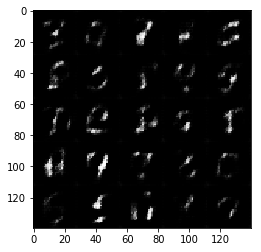

Epoch 1/2... Step 220... Discriminator Loss: 1.0231... Generator Loss: 0.9858
Epoch 1/2... Step 240... Discriminator Loss: 0.9315... Generator Loss: 1.9865
Epoch 1/2... Step 260... Discriminator Loss: 0.6820... Generator Loss: 1.3119
Epoch 1/2... Step 280... Discriminator Loss: 0.9549... Generator Loss: 2.4546
Epoch 1/2... Step 300... Discriminator Loss: 1.0450... Generator Loss: 1.4477
Epoch 1/2... Step 320... Discriminator Loss: 0.9081... Generator Loss: 1.2500
Epoch 1/2... Step 340... Discriminator Loss: 0.8611... Generator Loss: 1.5045
Epoch 1/2... Step 360... Discriminator Loss: 0.8547... Generator Loss: 0.9234
Epoch 1/2... Step 380... Discriminator Loss: 0.7447... Generator Loss: 1.5232
Epoch 1/2... Step 400... Discriminator Loss: 0.7621... Generator Loss: 1.2972


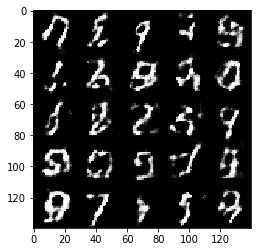

Epoch 1/2... Step 420... Discriminator Loss: 0.9023... Generator Loss: 1.0538
Epoch 1/2... Step 440... Discriminator Loss: 0.9004... Generator Loss: 0.9433
Epoch 1/2... Step 460... Discriminator Loss: 0.7969... Generator Loss: 1.1906
Epoch 1/2... Step 480... Discriminator Loss: 0.8665... Generator Loss: 0.9082
Epoch 1/2... Step 500... Discriminator Loss: 1.0669... Generator Loss: 0.7655
Epoch 1/2... Step 520... Discriminator Loss: 0.6623... Generator Loss: 1.6834
Epoch 1/2... Step 540... Discriminator Loss: 0.9503... Generator Loss: 0.8687
Epoch 1/2... Step 560... Discriminator Loss: 1.1870... Generator Loss: 2.0250
Epoch 1/2... Step 580... Discriminator Loss: 0.7430... Generator Loss: 1.1538
Epoch 1/2... Step 600... Discriminator Loss: 0.8736... Generator Loss: 1.4739


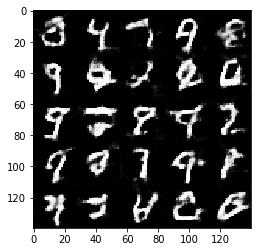

Epoch 1/2... Step 620... Discriminator Loss: 0.8398... Generator Loss: 0.9504
Epoch 1/2... Step 640... Discriminator Loss: 0.9930... Generator Loss: 0.7446
Epoch 1/2... Step 660... Discriminator Loss: 0.8909... Generator Loss: 1.3853
Epoch 1/2... Step 680... Discriminator Loss: 1.1527... Generator Loss: 1.1237
Epoch 1/2... Step 700... Discriminator Loss: 0.7005... Generator Loss: 1.6946
Epoch 1/2... Step 720... Discriminator Loss: 0.9693... Generator Loss: 1.6265
Epoch 1/2... Step 740... Discriminator Loss: 0.8660... Generator Loss: 1.1882
Epoch 1/2... Step 760... Discriminator Loss: 0.8692... Generator Loss: 1.0023
Epoch 1/2... Step 780... Discriminator Loss: 0.8746... Generator Loss: 1.7111
Epoch 1/2... Step 800... Discriminator Loss: 0.6761... Generator Loss: 1.2147


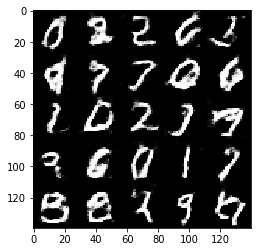

Epoch 1/2... Step 820... Discriminator Loss: 0.8349... Generator Loss: 2.3251
Epoch 1/2... Step 840... Discriminator Loss: 1.0215... Generator Loss: 0.6794
Epoch 1/2... Step 860... Discriminator Loss: 1.1471... Generator Loss: 0.6823
Epoch 1/2... Step 880... Discriminator Loss: 0.8965... Generator Loss: 0.8509
Epoch 1/2... Step 900... Discriminator Loss: 0.8419... Generator Loss: 0.8097
Epoch 1/2... Step 920... Discriminator Loss: 0.7738... Generator Loss: 1.8422


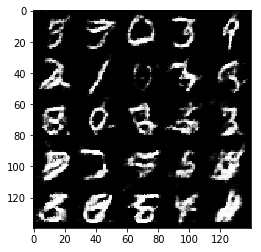

Epoch Done.
Epoch 2/2... Step 940... Discriminator Loss: 0.6739... Generator Loss: 1.2286
Epoch 2/2... Step 960... Discriminator Loss: 0.7565... Generator Loss: 0.9151
Epoch 2/2... Step 980... Discriminator Loss: 0.9108... Generator Loss: 0.8422
Epoch 2/2... Step 1000... Discriminator Loss: 1.1197... Generator Loss: 0.6146


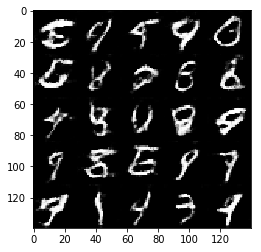

Epoch 2/2... Step 1020... Discriminator Loss: 1.6351... Generator Loss: 0.3078
Epoch 2/2... Step 1040... Discriminator Loss: 0.8156... Generator Loss: 0.9861
Epoch 2/2... Step 1060... Discriminator Loss: 1.1650... Generator Loss: 0.5640
Epoch 2/2... Step 1080... Discriminator Loss: 0.7359... Generator Loss: 1.7439
Epoch 2/2... Step 1100... Discriminator Loss: 0.7830... Generator Loss: 0.9212
Epoch 2/2... Step 1120... Discriminator Loss: 0.8203... Generator Loss: 0.9478
Epoch 2/2... Step 1140... Discriminator Loss: 1.0755... Generator Loss: 0.5967
Epoch 2/2... Step 1160... Discriminator Loss: 1.2119... Generator Loss: 0.5549
Epoch 2/2... Step 1180... Discriminator Loss: 0.7183... Generator Loss: 1.2208
Epoch 2/2... Step 1200... Discriminator Loss: 0.8345... Generator Loss: 0.7647


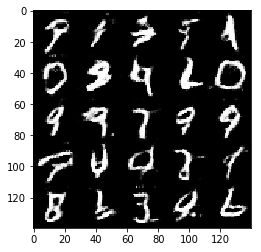

Epoch 2/2... Step 1220... Discriminator Loss: 0.7579... Generator Loss: 0.9862
Epoch 2/2... Step 1240... Discriminator Loss: 0.7042... Generator Loss: 1.3806
Epoch 2/2... Step 1260... Discriminator Loss: 0.8376... Generator Loss: 0.8966
Epoch 2/2... Step 1280... Discriminator Loss: 2.9146... Generator Loss: 0.1082
Epoch 2/2... Step 1300... Discriminator Loss: 0.8875... Generator Loss: 0.9632
Epoch 2/2... Step 1320... Discriminator Loss: 0.9374... Generator Loss: 0.8090
Epoch 2/2... Step 1340... Discriminator Loss: 0.8632... Generator Loss: 1.0051
Epoch 2/2... Step 1360... Discriminator Loss: 0.8483... Generator Loss: 1.6485
Epoch 2/2... Step 1380... Discriminator Loss: 0.6482... Generator Loss: 1.2579
Epoch 2/2... Step 1400... Discriminator Loss: 0.8513... Generator Loss: 1.4751


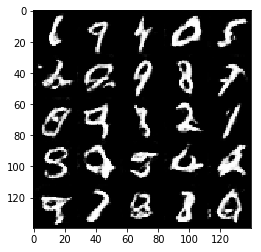

Epoch 2/2... Step 1420... Discriminator Loss: 1.4899... Generator Loss: 0.3811
Epoch 2/2... Step 1440... Discriminator Loss: 1.0406... Generator Loss: 1.8612
Epoch 2/2... Step 1460... Discriminator Loss: 0.5693... Generator Loss: 1.7377
Epoch 2/2... Step 1480... Discriminator Loss: 0.9426... Generator Loss: 0.8077
Epoch 2/2... Step 1500... Discriminator Loss: 1.2859... Generator Loss: 0.4988
Epoch 2/2... Step 1520... Discriminator Loss: 1.1890... Generator Loss: 0.5200
Epoch 2/2... Step 1540... Discriminator Loss: 0.5256... Generator Loss: 1.8390
Epoch 2/2... Step 1560... Discriminator Loss: 1.1786... Generator Loss: 0.7183
Epoch 2/2... Step 1580... Discriminator Loss: 0.9650... Generator Loss: 0.6660
Epoch 2/2... Step 1600... Discriminator Loss: 0.6743... Generator Loss: 1.0981


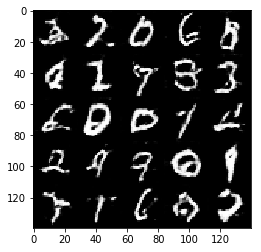

Epoch 2/2... Step 1620... Discriminator Loss: 0.6542... Generator Loss: 1.5454
Epoch 2/2... Step 1640... Discriminator Loss: 0.7321... Generator Loss: 1.2674
Epoch 2/2... Step 1660... Discriminator Loss: 0.7073... Generator Loss: 1.3434
Epoch 2/2... Step 1680... Discriminator Loss: 0.6871... Generator Loss: 1.2007
Epoch 2/2... Step 1700... Discriminator Loss: 0.6656... Generator Loss: 1.1211
Epoch 2/2... Step 1720... Discriminator Loss: 0.6753... Generator Loss: 1.1284
Epoch 2/2... Step 1740... Discriminator Loss: 1.2230... Generator Loss: 0.6218
Epoch 2/2... Step 1760... Discriminator Loss: 0.7974... Generator Loss: 1.7905
Epoch 2/2... Step 1780... Discriminator Loss: 0.8071... Generator Loss: 1.2098
Epoch 2/2... Step 1800... Discriminator Loss: 0.6138... Generator Loss: 1.3011


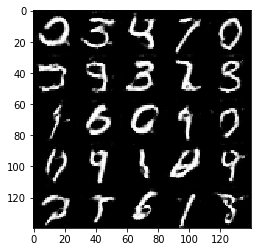

Epoch 2/2... Step 1820... Discriminator Loss: 0.7896... Generator Loss: 1.6243
Epoch 2/2... Step 1840... Discriminator Loss: 0.8025... Generator Loss: 1.9373
Epoch 2/2... Step 1860... Discriminator Loss: 0.6112... Generator Loss: 1.8000


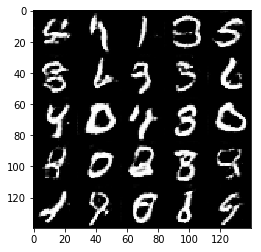

Epoch Done.


In [97]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.6

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 20... Discriminator Loss: 0.4480... Generator Loss: 1.5388
Epoch 1/1... Step 40... Discriminator Loss: 0.6218... Generator Loss: 1.1177
Epoch 1/1... Step 60... Discriminator Loss: 0.4555... Generator Loss: 3.1412
Epoch 1/1... Step 80... Discriminator Loss: 0.5523... Generator Loss: 1.3042
Epoch 1/1... Step 100... Discriminator Loss: 0.3225... Generator Loss: 2.0483
Epoch 1/1... Step 120... Discriminator Loss: 0.1278... Generator Loss: 5.6807
Epoch 1/1... Step 140... Discriminator Loss: 1.5050... Generator Loss: 10.0829
Epoch 1/1... Step 160... Discriminator Loss: 2.6121... Generator Loss: 0.1529
Epoch 1/1... Step 180... Discriminator Loss: 0.1347... Generator Loss: 5.4495
Epoch 1/1... Step 200... Discriminator Loss: 0.2706... Generator Loss: 2.2281


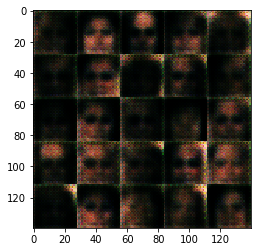

Epoch 1/1... Step 220... Discriminator Loss: 0.6122... Generator Loss: 1.1323
Epoch 1/1... Step 240... Discriminator Loss: 1.7152... Generator Loss: 0.5645
Epoch 1/1... Step 260... Discriminator Loss: 1.4846... Generator Loss: 0.7246
Epoch 1/1... Step 280... Discriminator Loss: 1.4320... Generator Loss: 0.4761
Epoch 1/1... Step 300... Discriminator Loss: 0.7442... Generator Loss: 1.3552
Epoch 1/1... Step 320... Discriminator Loss: 1.4040... Generator Loss: 0.4994
Epoch 1/1... Step 340... Discriminator Loss: 0.6198... Generator Loss: 1.0323
Epoch 1/1... Step 360... Discriminator Loss: 0.2378... Generator Loss: 5.2589
Epoch 1/1... Step 380... Discriminator Loss: 0.1729... Generator Loss: 5.4105
Epoch 1/1... Step 400... Discriminator Loss: 0.2579... Generator Loss: 7.3018


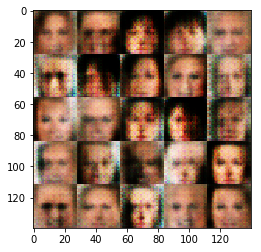

Epoch 1/1... Step 420... Discriminator Loss: 0.5360... Generator Loss: 8.9207
Epoch 1/1... Step 440... Discriminator Loss: 0.5663... Generator Loss: 1.1588
Epoch 1/1... Step 460... Discriminator Loss: 0.3483... Generator Loss: 2.4238
Epoch 1/1... Step 480... Discriminator Loss: 0.4374... Generator Loss: 8.5661
Epoch 1/1... Step 500... Discriminator Loss: 0.4463... Generator Loss: 1.9646
Epoch 1/1... Step 520... Discriminator Loss: 0.3738... Generator Loss: 3.6619
Epoch 1/1... Step 540... Discriminator Loss: 0.3899... Generator Loss: 1.4662
Epoch 1/1... Step 560... Discriminator Loss: 0.7288... Generator Loss: 6.0030
Epoch 1/1... Step 580... Discriminator Loss: 0.3882... Generator Loss: 4.5645
Epoch 1/1... Step 600... Discriminator Loss: 0.2954... Generator Loss: 2.3001


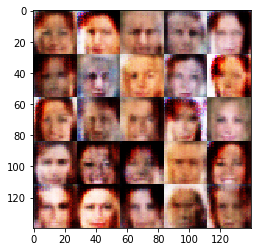

Epoch 1/1... Step 620... Discriminator Loss: 1.0116... Generator Loss: 0.7155
Epoch 1/1... Step 640... Discriminator Loss: 0.7770... Generator Loss: 7.9307
Epoch 1/1... Step 660... Discriminator Loss: 0.4665... Generator Loss: 1.4804
Epoch 1/1... Step 680... Discriminator Loss: 0.1036... Generator Loss: 5.1815
Epoch 1/1... Step 700... Discriminator Loss: 0.2158... Generator Loss: 5.0895
Epoch 1/1... Step 720... Discriminator Loss: 0.4218... Generator Loss: 1.6853
Epoch 1/1... Step 740... Discriminator Loss: 0.6602... Generator Loss: 1.0605
Epoch 1/1... Step 760... Discriminator Loss: 0.0739... Generator Loss: 4.8867
Epoch 1/1... Step 780... Discriminator Loss: 1.5907... Generator Loss: 0.3228
Epoch 1/1... Step 800... Discriminator Loss: 0.5210... Generator Loss: 2.2440


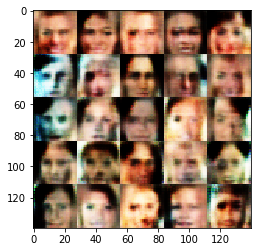

Epoch 1/1... Step 820... Discriminator Loss: 0.0705... Generator Loss: 7.2625
Epoch 1/1... Step 840... Discriminator Loss: 0.1677... Generator Loss: 5.9048
Epoch 1/1... Step 860... Discriminator Loss: 0.3878... Generator Loss: 1.9558
Epoch 1/1... Step 880... Discriminator Loss: 0.0652... Generator Loss: 4.0828
Epoch 1/1... Step 900... Discriminator Loss: 0.3520... Generator Loss: 1.6757
Epoch 1/1... Step 920... Discriminator Loss: 0.0922... Generator Loss: 6.6355
Epoch 1/1... Step 940... Discriminator Loss: 0.3649... Generator Loss: 1.5963
Epoch 1/1... Step 960... Discriminator Loss: 0.3180... Generator Loss: 6.0277
Epoch 1/1... Step 980... Discriminator Loss: 0.1580... Generator Loss: 3.3299
Epoch 1/1... Step 1000... Discriminator Loss: 0.0411... Generator Loss: 5.8393


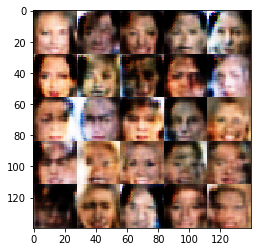

Epoch 1/1... Step 1020... Discriminator Loss: 0.2802... Generator Loss: 2.2691
Epoch 1/1... Step 1040... Discriminator Loss: 0.2102... Generator Loss: 2.2576
Epoch 1/1... Step 1060... Discriminator Loss: 0.1011... Generator Loss: 4.7132
Epoch 1/1... Step 1080... Discriminator Loss: 1.4982... Generator Loss: 0.3840
Epoch 1/1... Step 1100... Discriminator Loss: 0.2040... Generator Loss: 5.1764
Epoch 1/1... Step 1120... Discriminator Loss: 0.8150... Generator Loss: 0.8812
Epoch 1/1... Step 1140... Discriminator Loss: 0.1520... Generator Loss: 5.2508
Epoch 1/1... Step 1160... Discriminator Loss: 0.3120... Generator Loss: 5.2805
Epoch 1/1... Step 1180... Discriminator Loss: 0.2217... Generator Loss: 2.1537
Epoch 1/1... Step 1200... Discriminator Loss: 0.1757... Generator Loss: 6.6140


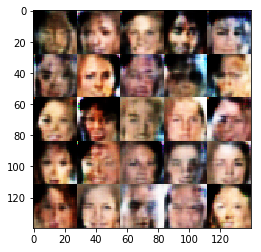

Epoch 1/1... Step 1220... Discriminator Loss: 0.2146... Generator Loss: 2.7057
Epoch 1/1... Step 1240... Discriminator Loss: 0.1592... Generator Loss: 2.8835
Epoch 1/1... Step 1260... Discriminator Loss: 0.2577... Generator Loss: 2.6203
Epoch 1/1... Step 1280... Discriminator Loss: 0.0923... Generator Loss: 4.0461
Epoch 1/1... Step 1300... Discriminator Loss: 0.2851... Generator Loss: 1.7588
Epoch 1/1... Step 1320... Discriminator Loss: 0.1511... Generator Loss: 3.5453
Epoch 1/1... Step 1340... Discriminator Loss: 0.2418... Generator Loss: 3.5127
Epoch 1/1... Step 1360... Discriminator Loss: 0.1209... Generator Loss: 8.1049
Epoch 1/1... Step 1380... Discriminator Loss: 1.7336... Generator Loss: 0.4545
Epoch 1/1... Step 1400... Discriminator Loss: 0.6205... Generator Loss: 3.0706


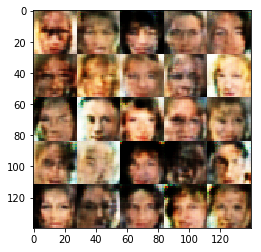

Epoch 1/1... Step 1420... Discriminator Loss: 0.4349... Generator Loss: 3.9690
Epoch 1/1... Step 1440... Discriminator Loss: 0.2820... Generator Loss: 4.1022
Epoch 1/1... Step 1460... Discriminator Loss: 0.0633... Generator Loss: 7.9470
Epoch 1/1... Step 1480... Discriminator Loss: 0.1826... Generator Loss: 2.8477
Epoch 1/1... Step 1500... Discriminator Loss: 0.5452... Generator Loss: 1.2941
Epoch 1/1... Step 1520... Discriminator Loss: 0.3307... Generator Loss: 1.7931
Epoch 1/1... Step 1540... Discriminator Loss: 0.0418... Generator Loss: 4.2655
Epoch 1/1... Step 1560... Discriminator Loss: 0.5211... Generator Loss: 1.2396
Epoch 1/1... Step 1580... Discriminator Loss: 0.3322... Generator Loss: 3.2003
Epoch 1/1... Step 1600... Discriminator Loss: 0.9201... Generator Loss: 0.6742


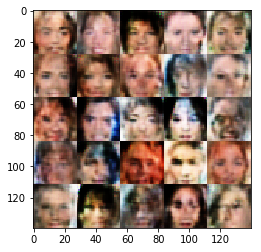

Epoch 1/1... Step 1620... Discriminator Loss: 0.1388... Generator Loss: 3.7134
Epoch 1/1... Step 1640... Discriminator Loss: 0.3515... Generator Loss: 3.3263
Epoch 1/1... Step 1660... Discriminator Loss: 1.1875... Generator Loss: 0.5199
Epoch 1/1... Step 1680... Discriminator Loss: 0.0500... Generator Loss: 4.5007
Epoch 1/1... Step 1700... Discriminator Loss: 0.5775... Generator Loss: 1.2656
Epoch 1/1... Step 1720... Discriminator Loss: 2.4142... Generator Loss: 0.1962
Epoch 1/1... Step 1740... Discriminator Loss: 0.3092... Generator Loss: 2.3248
Epoch 1/1... Step 1760... Discriminator Loss: 0.3779... Generator Loss: 1.9711
Epoch 1/1... Step 1780... Discriminator Loss: 0.4476... Generator Loss: 2.1731
Epoch 1/1... Step 1800... Discriminator Loss: 0.2388... Generator Loss: 2.2166


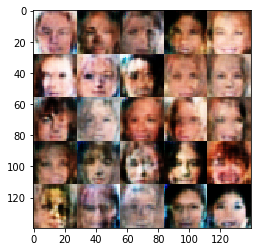

Epoch 1/1... Step 1820... Discriminator Loss: 0.0715... Generator Loss: 3.8393
Epoch 1/1... Step 1840... Discriminator Loss: 1.1014... Generator Loss: 0.6038
Epoch 1/1... Step 1860... Discriminator Loss: 0.4055... Generator Loss: 1.9640
Epoch 1/1... Step 1880... Discriminator Loss: 0.7557... Generator Loss: 0.9369
Epoch 1/1... Step 1900... Discriminator Loss: 0.1028... Generator Loss: 3.7748
Epoch 1/1... Step 1920... Discriminator Loss: 0.2865... Generator Loss: 2.2113
Epoch 1/1... Step 1940... Discriminator Loss: 0.3503... Generator Loss: 2.8262
Epoch 1/1... Step 1960... Discriminator Loss: 0.6094... Generator Loss: 4.0982
Epoch 1/1... Step 1980... Discriminator Loss: 0.2345... Generator Loss: 3.0599
Epoch 1/1... Step 2000... Discriminator Loss: 0.2390... Generator Loss: 2.0670


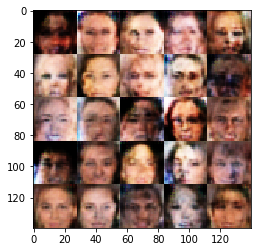

Epoch 1/1... Step 2020... Discriminator Loss: 0.2178... Generator Loss: 2.1899
Epoch 1/1... Step 2040... Discriminator Loss: 0.3894... Generator Loss: 1.6347
Epoch 1/1... Step 2060... Discriminator Loss: 0.2264... Generator Loss: 3.4228
Epoch 1/1... Step 2080... Discriminator Loss: 0.1116... Generator Loss: 3.5050
Epoch 1/1... Step 2100... Discriminator Loss: 0.0453... Generator Loss: 5.1082
Epoch 1/1... Step 2120... Discriminator Loss: 2.0832... Generator Loss: 4.9969
Epoch 1/1... Step 2140... Discriminator Loss: 0.9620... Generator Loss: 3.4288
Epoch 1/1... Step 2160... Discriminator Loss: 0.9203... Generator Loss: 5.7558
Epoch 1/1... Step 2180... Discriminator Loss: 0.5660... Generator Loss: 1.3988
Epoch 1/1... Step 2200... Discriminator Loss: 0.6575... Generator Loss: 3.1781


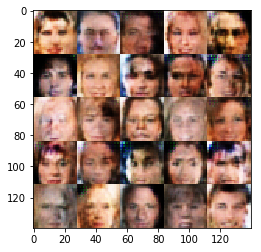

Epoch 1/1... Step 2220... Discriminator Loss: 0.6924... Generator Loss: 1.1468
Epoch 1/1... Step 2240... Discriminator Loss: 0.7183... Generator Loss: 1.6498
Epoch 1/1... Step 2260... Discriminator Loss: 0.3585... Generator Loss: 1.6757
Epoch 1/1... Step 2280... Discriminator Loss: 0.2871... Generator Loss: 2.1455
Epoch 1/1... Step 2300... Discriminator Loss: 0.3923... Generator Loss: 1.8014
Epoch 1/1... Step 2320... Discriminator Loss: 0.2086... Generator Loss: 2.2561
Epoch 1/1... Step 2340... Discriminator Loss: 0.4240... Generator Loss: 1.6879
Epoch 1/1... Step 2360... Discriminator Loss: 0.0726... Generator Loss: 4.0621
Epoch 1/1... Step 2380... Discriminator Loss: 0.4655... Generator Loss: 1.8172
Epoch 1/1... Step 2400... Discriminator Loss: 0.6645... Generator Loss: 1.0774


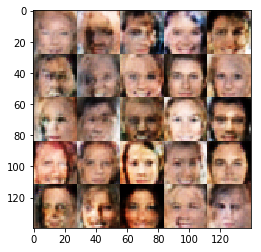

Epoch 1/1... Step 2420... Discriminator Loss: 0.3053... Generator Loss: 3.2936
Epoch 1/1... Step 2440... Discriminator Loss: 0.6187... Generator Loss: 1.2267
Epoch 1/1... Step 2460... Discriminator Loss: 0.3130... Generator Loss: 2.0119
Epoch 1/1... Step 2480... Discriminator Loss: 0.3919... Generator Loss: 1.7628
Epoch 1/1... Step 2500... Discriminator Loss: 0.2674... Generator Loss: 3.7634
Epoch 1/1... Step 2520... Discriminator Loss: 0.1624... Generator Loss: 2.5936
Epoch 1/1... Step 2540... Discriminator Loss: 0.2635... Generator Loss: 4.4319
Epoch 1/1... Step 2560... Discriminator Loss: 0.5717... Generator Loss: 1.4558
Epoch 1/1... Step 2580... Discriminator Loss: 0.6759... Generator Loss: 1.1339
Epoch 1/1... Step 2600... Discriminator Loss: 0.3189... Generator Loss: 2.4874


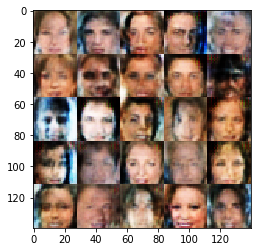

Epoch 1/1... Step 2620... Discriminator Loss: 0.3200... Generator Loss: 4.6482
Epoch 1/1... Step 2640... Discriminator Loss: 0.5961... Generator Loss: 1.8200
Epoch 1/1... Step 2660... Discriminator Loss: 0.6108... Generator Loss: 1.1747
Epoch 1/1... Step 2680... Discriminator Loss: 0.3096... Generator Loss: 2.1124
Epoch 1/1... Step 2700... Discriminator Loss: 0.8334... Generator Loss: 2.7420
Epoch 1/1... Step 2720... Discriminator Loss: 0.2456... Generator Loss: 2.3082
Epoch 1/1... Step 2740... Discriminator Loss: 0.7083... Generator Loss: 1.0819
Epoch 1/1... Step 2760... Discriminator Loss: 0.0625... Generator Loss: 7.4708
Epoch 1/1... Step 2780... Discriminator Loss: 0.1032... Generator Loss: 4.2081
Epoch 1/1... Step 2800... Discriminator Loss: 2.1750... Generator Loss: 0.2470


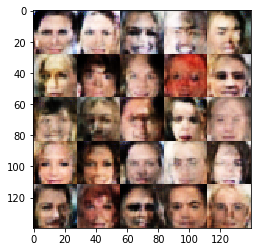

Epoch 1/1... Step 2820... Discriminator Loss: 1.4070... Generator Loss: 0.4289
Epoch 1/1... Step 2840... Discriminator Loss: 0.6961... Generator Loss: 1.4384
Epoch 1/1... Step 2860... Discriminator Loss: 0.5773... Generator Loss: 1.3409
Epoch 1/1... Step 2880... Discriminator Loss: 0.2683... Generator Loss: 2.5864
Epoch 1/1... Step 2900... Discriminator Loss: 0.3706... Generator Loss: 1.8567
Epoch 1/1... Step 2920... Discriminator Loss: 1.0862... Generator Loss: 3.2912
Epoch 1/1... Step 2940... Discriminator Loss: 1.4980... Generator Loss: 0.5314
Epoch 1/1... Step 2960... Discriminator Loss: 0.1445... Generator Loss: 3.3460
Epoch 1/1... Step 2980... Discriminator Loss: 0.3184... Generator Loss: 2.3795
Epoch 1/1... Step 3000... Discriminator Loss: 0.1990... Generator Loss: 2.6505


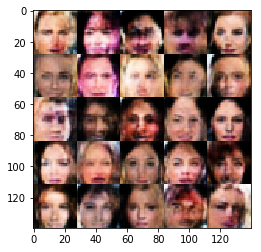

Epoch 1/1... Step 3020... Discriminator Loss: 0.3254... Generator Loss: 1.6128
Epoch 1/1... Step 3040... Discriminator Loss: 0.3787... Generator Loss: 1.7071
Epoch 1/1... Step 3060... Discriminator Loss: 0.7670... Generator Loss: 1.2213
Epoch 1/1... Step 3080... Discriminator Loss: 0.0783... Generator Loss: 5.0051
Epoch 1/1... Step 3100... Discriminator Loss: 0.3412... Generator Loss: 1.9878
Epoch 1/1... Step 3120... Discriminator Loss: 0.2257... Generator Loss: 2.5714
Epoch 1/1... Step 3140... Discriminator Loss: 0.3796... Generator Loss: 1.5492


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.6

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.